In [31]:
!pip install opencv-python numpy matplotlib

In [32]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

# Smart histogram descriptor

In [33]:
images = {}
for folder in os.listdir('img'):
    for file in os.listdir(f'img/{folder}'):
        images[f"{folder.replace(' ', '-')}-{file.replace('.jpg', '')}"] = cv.imread(f'img/{folder}/{file}', cv.IMREAD_COLOR)

#### He quitado el tipo a las listas, si no no me ejecutaba

In [34]:
def get_sub_images(image, row_sizes: list, col_sizes: list):
    sub_images = []
    for i in range(len(row_sizes) - 1):
        for j in range(len(col_sizes) - 1):
            sub_images.append(image[row_sizes[i]:row_sizes[i+1], col_sizes[j]:col_sizes[j+1]])
    return sub_images

In [35]:
def get_histograms(imgs):
    color = ('b','g','r')
    hists = {}
    for name, img in imgs.items():
        hist = []
        for sub_img in img:
            histr = []
            for i, col in enumerate(color):
                histr.append(cv.calcHist([sub_img], [i], None, [256 // 64], [0, 256]))
            hist.append(histr)
        hists[name] = hist
    return hists

In [52]:
selected_img = 'three-of-hearts-1'

In [37]:
def calculate_distance_sub_img(sub_img1, sub_img2):
    distance = 0
    for i in range(3):
        distance += cv.compareHist(sub_img1[i], sub_img2[i], cv.HISTCMP_CHISQR)
    return distance / 3

In [38]:
def calculate_distance_img(img1, img2):
    distance = 0
    weights = ([0.15] + [0.1 / 12] * 4) + ([0.1 / 12, 0.6 / 6, 0.6 / 6, 0.6 / 6, 0.1 / 12] * 2) + [0.1 / 12] * 4 + [0.15]
    for i in range(len(img1)):
        distance += weights[i] * calculate_distance_sub_img(img1[i], img2[i])
    return distance

In [39]:
def calculate_distances_to_all_images_hist(images, selected_img):
    images_divided = {name: get_sub_images(image, row_sizes=[0, 56, 112, 168, 224], col_sizes=[0, 45, 90, 135, 179, 224]) for name, image in images.items()}
    images_divided_hist = get_histograms(images_divided)
    dist = {name: calculate_distance_img(images_divided_hist[selected_img], img2) for name, img2 in images_divided_hist.items()}
    return dist

In [53]:
distances_hist = calculate_distances_to_all_images_hist(images, selected_img)

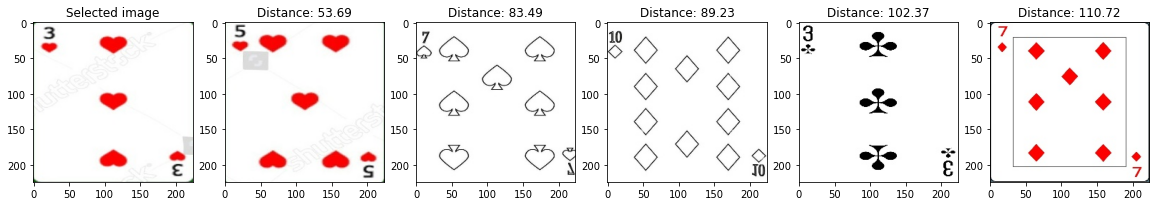

<Figure size 432x288 with 0 Axes>

In [54]:
# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hist_distances = sorted(distances_hist.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hist_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hist_distances[i][1]:.2f}')
plt.show()
plt.clf()

# HOG descriptor


In [58]:
def harris_hog_descriptor(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Harris Corner Detection
    harris_corners = cv.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv.dilate(harris_corners, None)##creo que esto no afecta demasiado

    # HOG Descriptor
    hog = cv.HOGDescriptor(_winSize = (220, 220), _blockSize = (112,90), _blockStride = (1, 1), _cellSize = (56,45), _nbins = 16)
    hog_descriptor = hog.compute(gray)

    return harris_corners, hog_descriptor

In [59]:
def calculate_distances_to_all_images_hog(images, selected_img):
    reference_harris, reference_hog = harris_hog_descriptor(images[selected_img])
    reference_descriptor = np.concatenate([reference_harris.flatten(), reference_hog.flatten()])
    
    dist = {}
    for name, img in images.items():
        other_harris, other_hog = harris_hog_descriptor(img)
        other_descriptor = np.concatenate([other_harris.flatten(), other_hog.flatten()])
        # Calculate euclidean distance
        #dist[name] = np.linalg.norm(reference_descriptor - other_descriptor)
        #Chi2 distance
        dist[name] = np.sum((reference_descriptor - other_descriptor)**2 / (reference_descriptor + other_descriptor + 1e-10))
    return dist



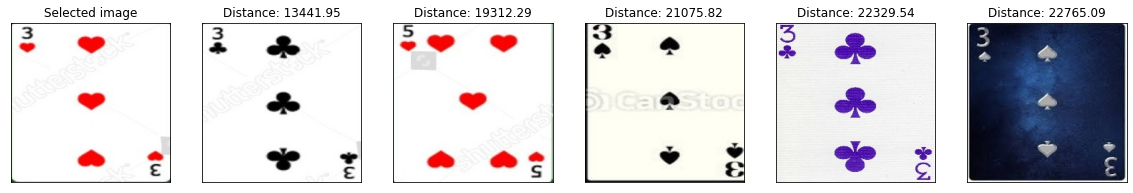

<Figure size 432x288 with 0 Axes>

In [60]:
#Calculate the distances to all images with HOG
distances_hog = calculate_distances_to_all_images_hog(images, selected_img)

# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hog_distances = sorted(distances_hog.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hog_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hog_distances[i][1]:.2f}')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()
plt.clf()

# Combine both descriptors
## Combine with weighted mean

In [61]:
normalized_hist_distances = {name: dist / ordered_hist_distances[-1][1]  for name, dist in distances_hist.items()}
normalized_hog_distances = {name: dist / ordered_hog_distances[-1][1] for name, dist in distances_hog.items()}

In [62]:
combined_distances = {}
hist_weight = 0.5
hog_weight = 1 - hist_weight
for name in images.keys():
    combined_distances[name] = (hist_weight * normalized_hist_distances[name] + hog_weight * normalized_hog_distances[name])

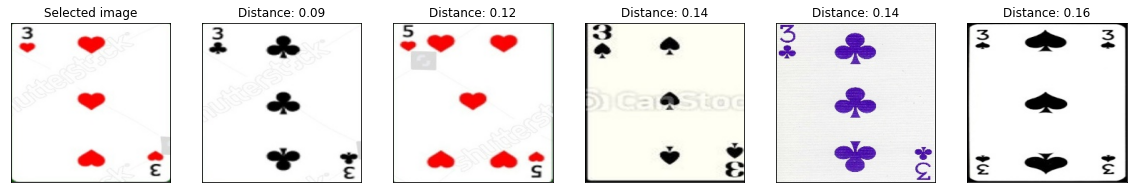

<Figure size 432x288 with 0 Axes>

In [63]:
# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_combined_distances = sorted(combined_distances.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_combined_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_combined_distances[i][1]:.2f}')
    
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()
plt.clf()

## Combine with two layer descriptor
### HOG -> Hist

In [ ]:
##se podria normalizar no? 

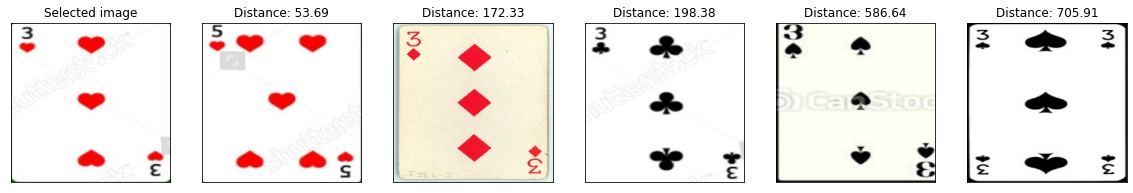

<Figure size 432x288 with 0 Axes>

In [64]:
number_of_best_images = 10
best_hog_images = {}
for i in range(number_of_best_images):
    best_hog_images[ordered_hog_distances[i][0]] = images[ordered_hog_distances[i][0]]

distances_hist_best_images = calculate_distances_to_all_images_hist(best_hog_images, selected_img)

# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hist_distances = sorted(distances_hist_best_images.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hist_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hist_distances[i][1]:.2f}')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()
plt.clf()

### Hist -> HOG

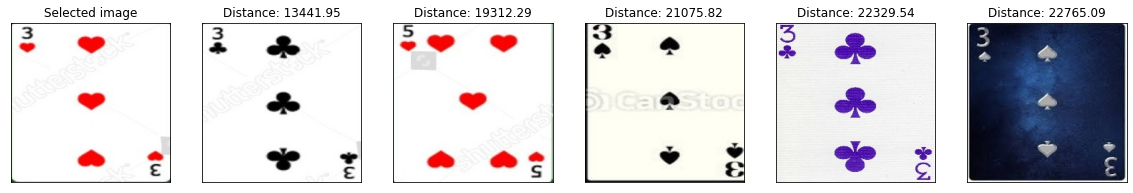

<Figure size 432x288 with 0 Axes>

In [65]:
best_hist_images = {}
for i in range(number_of_best_images):
    best_hist_images[ordered_hist_distances[i][0]] = images[ordered_hist_distances[i][0]]

distances_hog_best_images = calculate_distances_to_all_images_hog(best_hist_images, selected_img)

# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hog_distances = sorted(distances_hog_best_images.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hog_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hog_distances[i][1]:.2f}')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()
plt.clf()